In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

### Data from CSV

In [39]:
def plot_df(data: pd.DataFrame, fields=['precision', 'recall', 'f1', 'mean_iou'], aggregate=[], filter=[]):
    if filter:
        filter_field, filter_value = filter
        data[data[filter_field]==filter_value]

    if aggregate:
        agg_field, agg_method = aggregate
        data = data.groupby([agg_field], as_index=False)[fields]

        if agg_method == 'mean':
            data = data.mean()
        elif agg_method == 'sum':
            data = data.sum()
    
    data.set_index('model', inplace=True)
    data.plot(kind='bar', figsize=(10, 6))
    plt.show()

In [38]:
csv_path = r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\evaluation\csvs\2024_11_14.csv"
data = pd.read_csv(csv_path)

categories = [
'sam2.1 tiny',
'sam2.1 small',
'sam2.1 base+',
'sam2.1 large',
'fastsam_s',
'fastsam_x',
'yolo11n',
'yolo11s',
'yolo11m',
'yolo11l',
'yolo11x',

]
data['model'] = pd.Categorical(data['model'], categories=categories, ordered=True)
data.head()

,model,filename,model_params,augmentation,brightness,precipitation,surface,weather,ground_truth_objects,segmented_objects,matched_objects,precision,recall,f1,mean_iou,hardware
0,sam2.1 base+,base+_weti1_2024_11_14_12_47,NaN,NaN,bright,NaN,NaN,cloudy,14,41,9,0.219512,0.642857,0.327273,0.738776,"NVIDIA GeForce RTX 3060M, AMD Ryzen 7 5800H, 3..."
1,sam2.1 base+,base+_weti1_2024_11_14_12_47_m,NaN,NaN,bright,NaN,NaN,cloudy,14,12,7,0.583333,0.500000,0.538462,0.910393,"NVIDIA GeForce RTX 3060M, AMD Ryzen 7 5800H, 3..."
2,sam2.1 base+,base+_weti1_2024_11_14_12_57,NaN,NaN,bright,NaN,NaN,cloudy,14,44,8,0.181818,0.571429,0.275862,0.831882,"NVIDIA GeForce RTX 3060M, AMD Ryzen 7 5800H, 3..."
3,sam2.1 base+,base+_weti1_2024_11_14_12_57_m,NaN,NaN,bright,NaN,NaN,cloudy,14,12,7,0.583333,0.500000,0.538462,0.917293,"NVIDIA GeForce RTX 3060M, AMD Ryzen 7 5800H, 3..."
4,sam2.1 base+,base+_weti1_2024_11_14_13_07,NaN,NaN,bright,NaN,NaN,cloudy,14,39,8,0.205128,0.571429,0.301887,0.832884,"NVIDIA GeForce RTX 3060M, AMD Ryzen 7 5800H, 3..."


C:\Users\gtraw\AppData\Local\Temp\ipykernel_47492\2624240678.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data.groupby([agg_field], as_index=False)[fields]


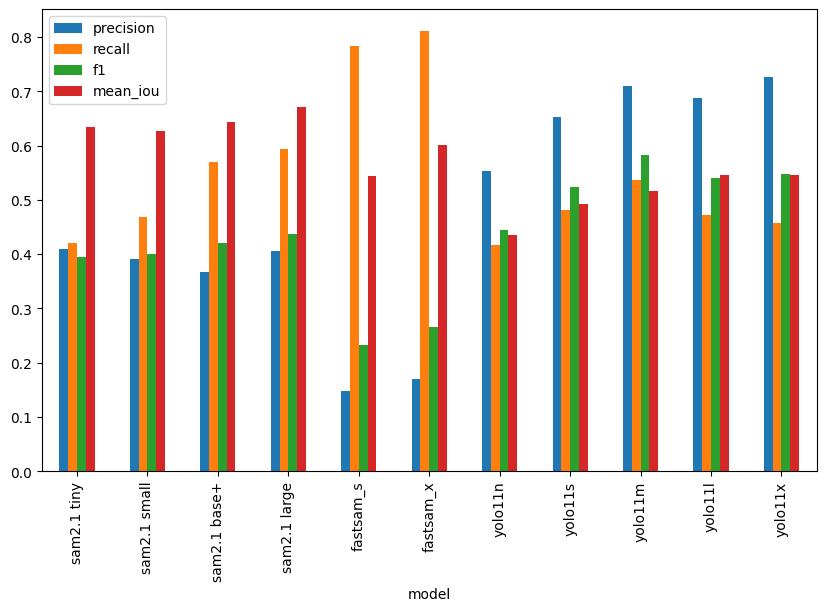

In [40]:
plot_df(data, aggregate=['model', 'mean'], filter=[])

<Axes: xlabel='model'>

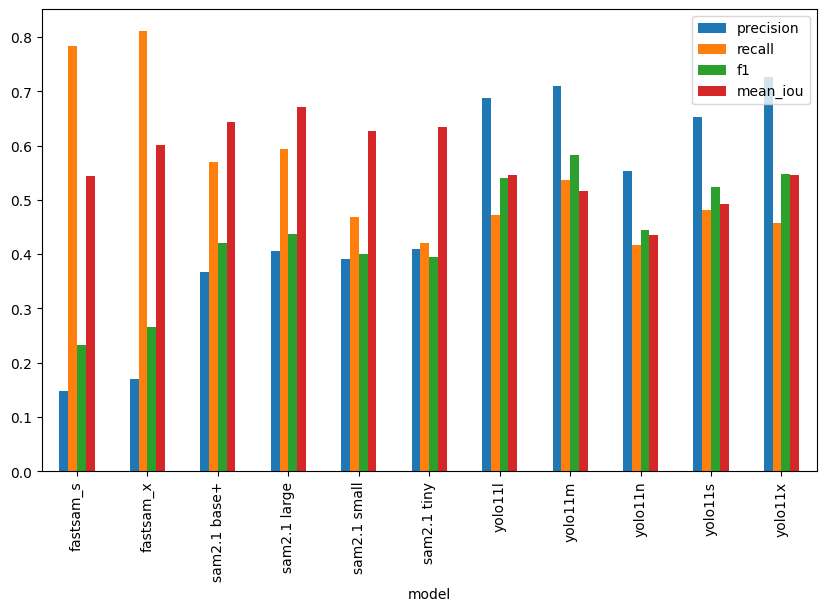

In [16]:
grouped = data.groupby(['model'], as_index=False)[['precision', 'recall', 'f1', 'mean_iou']].mean()
grouped.set_index('model', inplace=True)

# Plot the DataFrame
grouped.plot(kind='bar', figsize=(10, 6))

### Data from jsons

In [53]:
def aggregate_by_model(data, fields=['time', 'precision', 'recall', 'f1', 'mean_iou'],  conditions={}, name_condition={}, mean=True):
    model_data = {}

    for d in data:
        condition = True
        # name conditions
        if 'include' in name_condition:
            for n_cond in name_condition['include']:
                if n_cond not in d['name']:
                    condition = False
                    break
        if 'exclude' in name_condition:
            for n_cond in name_condition['exclude']:
                if n_cond in d['name']:
                    condition = False
                    break
        if not condition:
            continue
        
        # value conditions
        for k_cond, v_cond in conditions.items():
            if isinstance(d[k_cond], (list, tuple)) and v_cond not in d[k_cond]:
                condition = False
                break
            elif not isinstance(d[k_cond], (list, tuple)) and d[k_cond] != v_cond:
                condition = False
                break
        if not condition:
            continue

        model_name = ' '.join(d['model'])
        if model_name in model_data:
            for k in fields:
                if k in d:
                    if k not in model_data[model_name]:
                        model_data[model_name][k] = []
                        
                    model_data[model_name][k].append(d[k])
        else:
            model_data[model_name] = {k:[d[k]] for k in fields if k in d}
            
                # 'time': [d['time']],
                # 'precision': [d['precision']],
                # 'recall': [d['recall']],
                # 'f1' : [d['f1']],
                # 'mean_iou': [d['mean_iou']]

    # fix keys
    if 'sam2.1 standard_fast' in model_data:
        model_data['fastsam standard'] = model_data['sam2.1 standard_fast']
        model_data.pop('sam2.1 standard_fast')

    keys_og = list(model_data.keys())
    for k in keys_og:
        if 'yolo' in k:
            new_k = k.split()[-1]
            model_data[new_k] = model_data[k]
            model_data.pop(k)

    if mean:
        mean_model_data = {}

        for k in model_data:
            tmp_data = {}
            for kk, vv in model_data[k].items():
                tmp_data[kk] = sum(vv)/len(vv)
            mean_model_data[k] = tmp_data

        return mean_model_data
    else:
        return model_data

def plot_aggregated_data(data: dict, title='', print_values=False):
    groups = list(data.keys())
    fields = list(data[groups[0]].keys())

    data_values = {
        f: [data[g][f] for g in groups] for f in fields
    }
    data_values['names'] = groups

    df = pd.DataFrame(data_values)
    ax = df.plot(x='names', y=fields, kind='bar', title=title, figsize=(12, 6), rot=45)
    
    if print_values:
        for container in ax.containers:
            ax.bar_label(container)

def plot_aggregated_data2(data: dict, title=''):
    groups = list(data.keys())
    fields = list(data[groups[0]].keys())

    data_values = {f: [data[g][f] for g in groups] for f in fields}
    data_values['names'] = groups

    df = pd.DataFrame(data_values)
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    x = np.arange(len(groups))
    bar_width = 0.4

    bars1 = ax1.bar(x - bar_width/2, df[fields[0]], bar_width, label=fields[0], color='b', alpha=0.7)
    bars2 = ax2.bar(x + bar_width/2, df[fields[1]], bar_width, label=fields[1], color='r', alpha=0.7)

    for bars, ax in zip([bars1, bars2], [ax1, ax2]):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, rotation=45)

    ax1.set_ylabel(fields[0], color='b')
    ax2.set_ylabel(fields[1], color='r')
    ax1.set_xlabel('Groups')
    ax1.set_xticks(x)
    ax1.set_xticklabels(groups, rotation=15, ha='right')
    ax1.set_title(title)

    plt.tight_layout()
    plt.show()


In [3]:
# loading partial avaluations from jsons

input_dir = r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\evaluation\results\all"

data = []
for f in os.listdir(input_dir):
    if f.endswith('.json'):
        with open(os.path.join(input_dir, f), 'r') as json_file:
            json_data = json.load(json_file)
            json_data['name'] = f
            data.append(json_data)

In [20]:
data_models = aggregate_by_model(data, fields=['precision', 'recall', 'f1', 'mean_iou'])


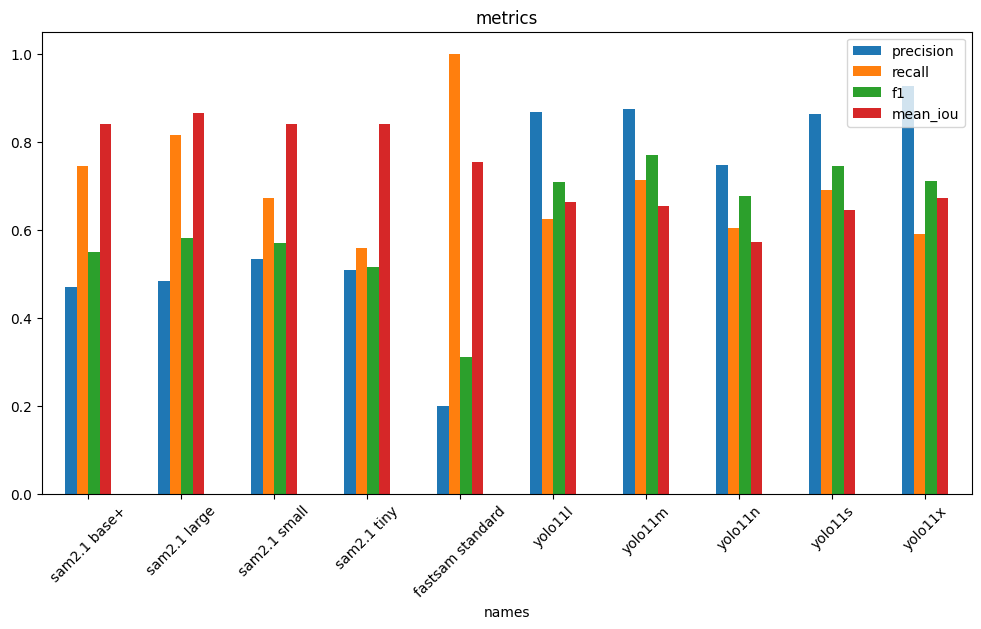

In [28]:
plot_aggregated_data(data_models, 'metrics')

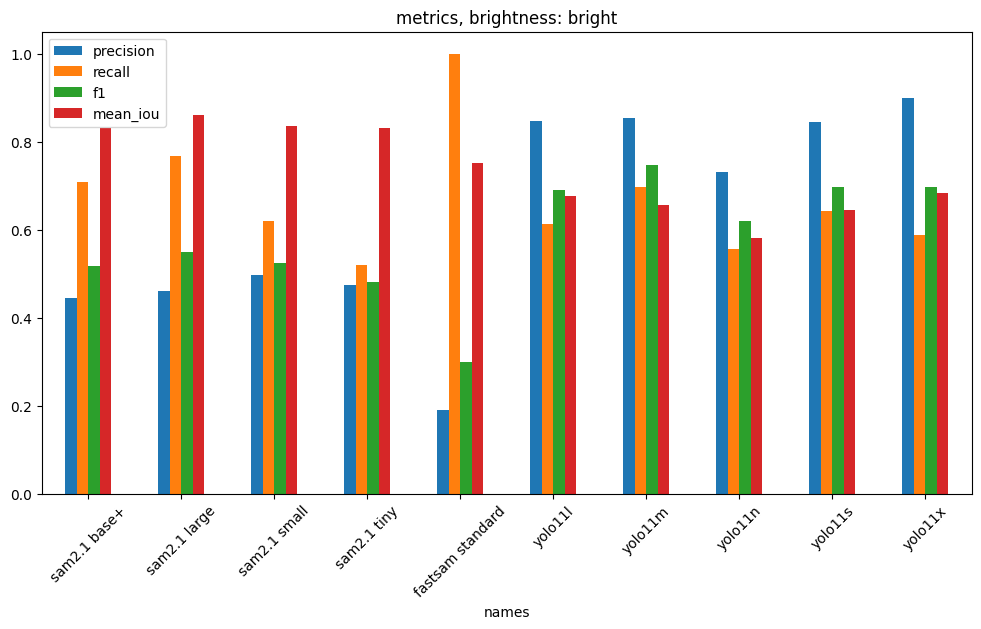

In [33]:
data_models = aggregate_by_model(data, fields=['precision', 'recall', 'f1', 'mean_iou'], conditions={'weather': 'bright'})
plot_aggregated_data(data_models, 'metrics, brightness: bright')

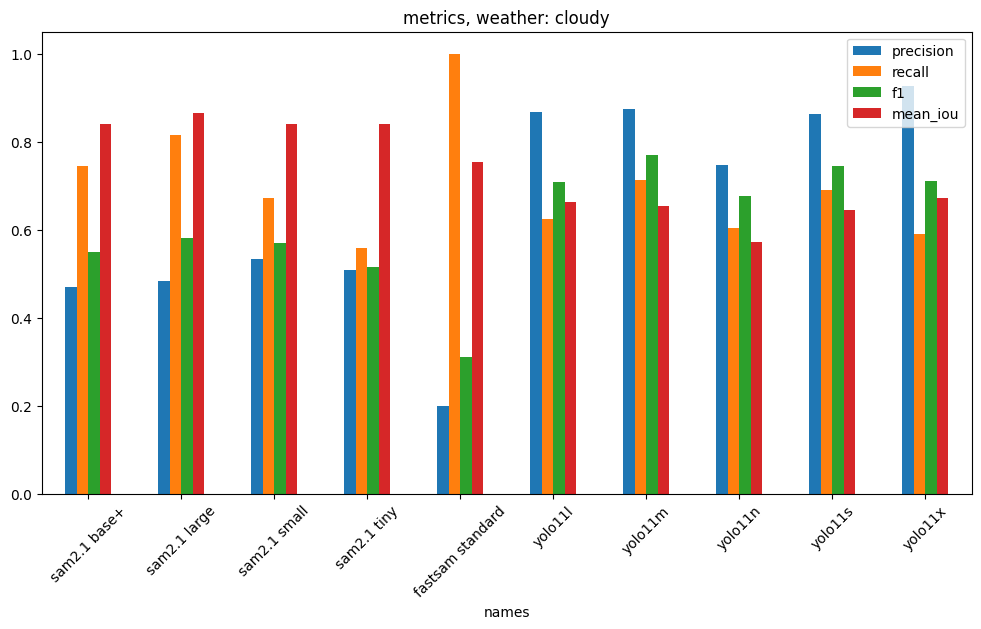

In [30]:
data_models = aggregate_by_model(data, fields=['precision', 'recall', 'f1', 'mean_iou'], conditions={'weather': 'cloudy'})
plot_aggregated_data(data_models, 'metrics, weather: cloudy')

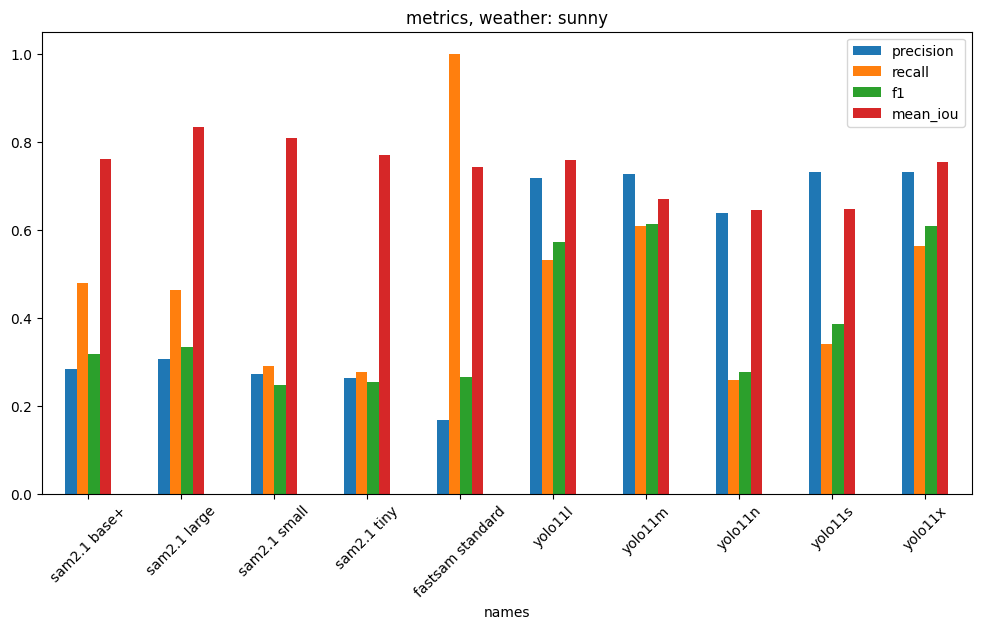

In [31]:
data_models = aggregate_by_model(data, fields=['precision', 'recall', 'f1', 'mean_iou'], conditions={'weather': 'sunny'})
plot_aggregated_data(data_models, 'metrics, weather: sunny')

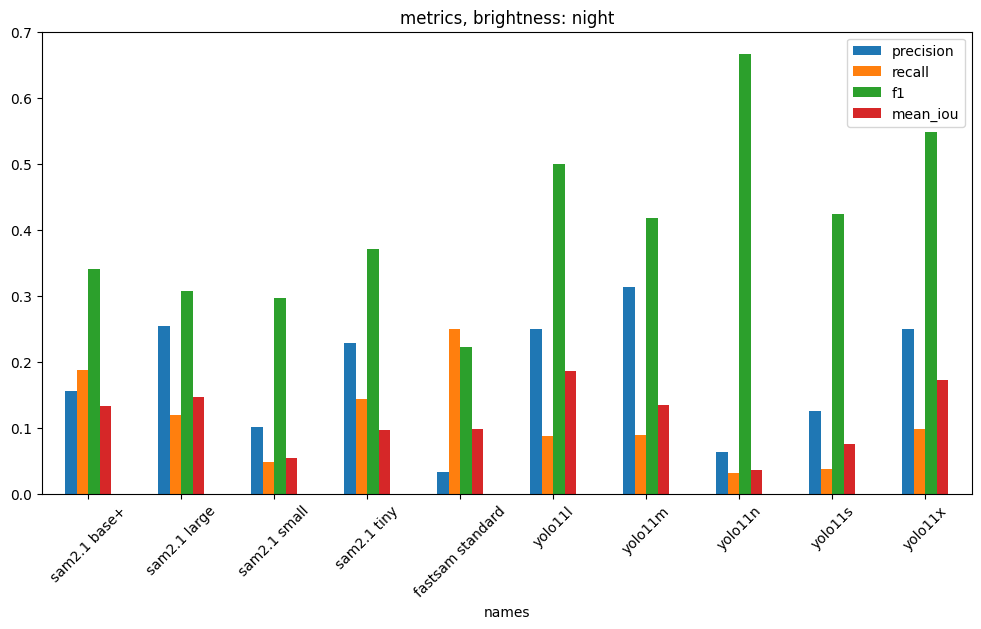

In [34]:
data_models = aggregate_by_model(data, fields=['precision', 'recall', 'f1', 'mean_iou'], conditions={'weather': 'night'})
plot_aggregated_data(data_models, 'metrics, brightness: night')

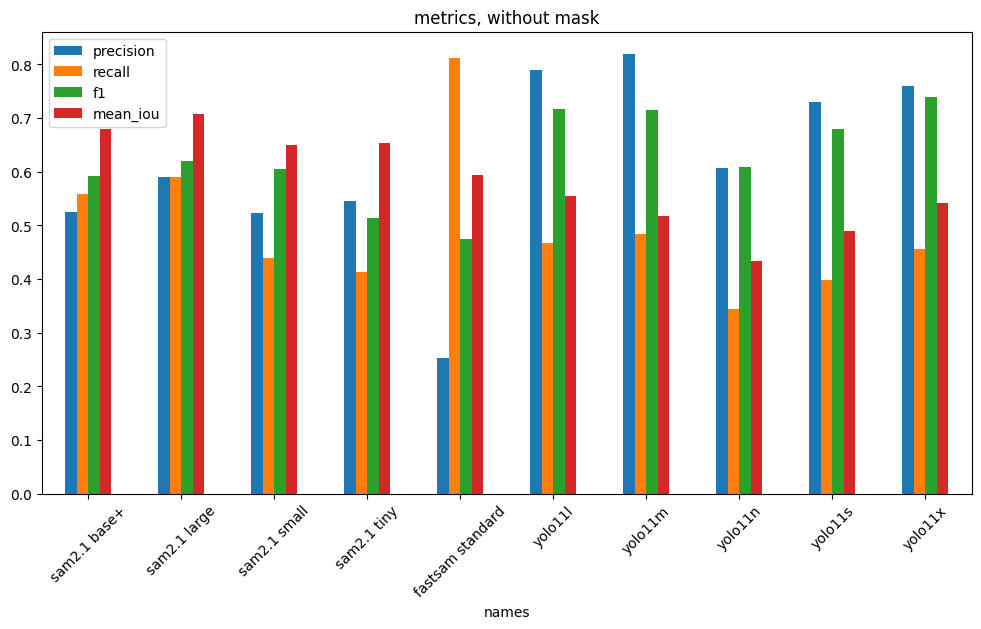

In [35]:
data_models = aggregate_by_model(data, fields=['precision', 'recall', 'f1', 'mean_iou'], name_condition={'exclude': ['_m']})
plot_aggregated_data(data_models, 'metrics, without mask')

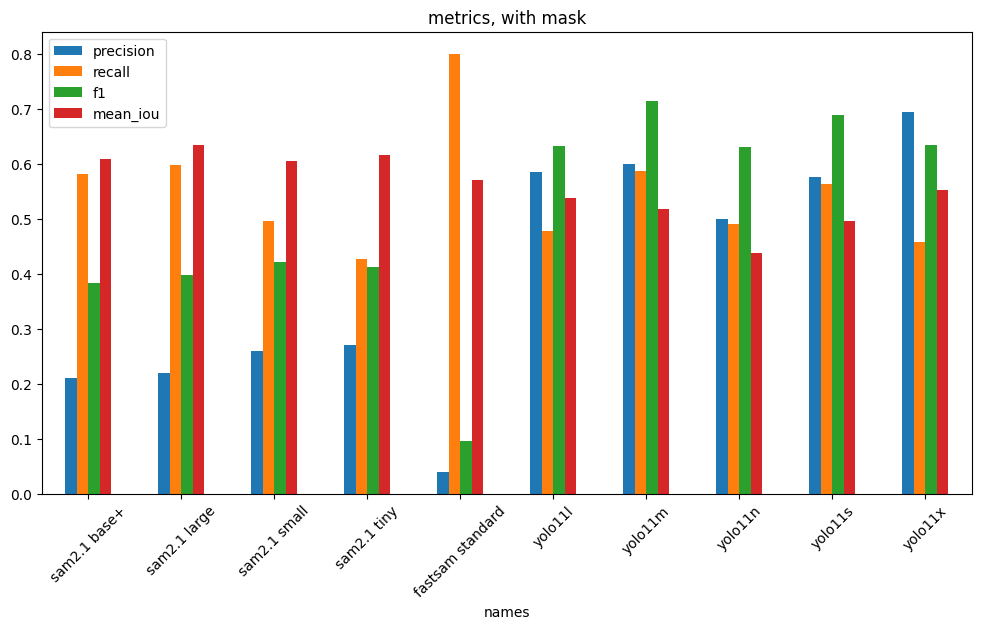

In [36]:
data_models = aggregate_by_model(data, fields=['precision', 'recall', 'f1', 'mean_iou'], name_condition={'include': ['_m']})
plot_aggregated_data(data_models, 'metrics, with mask')

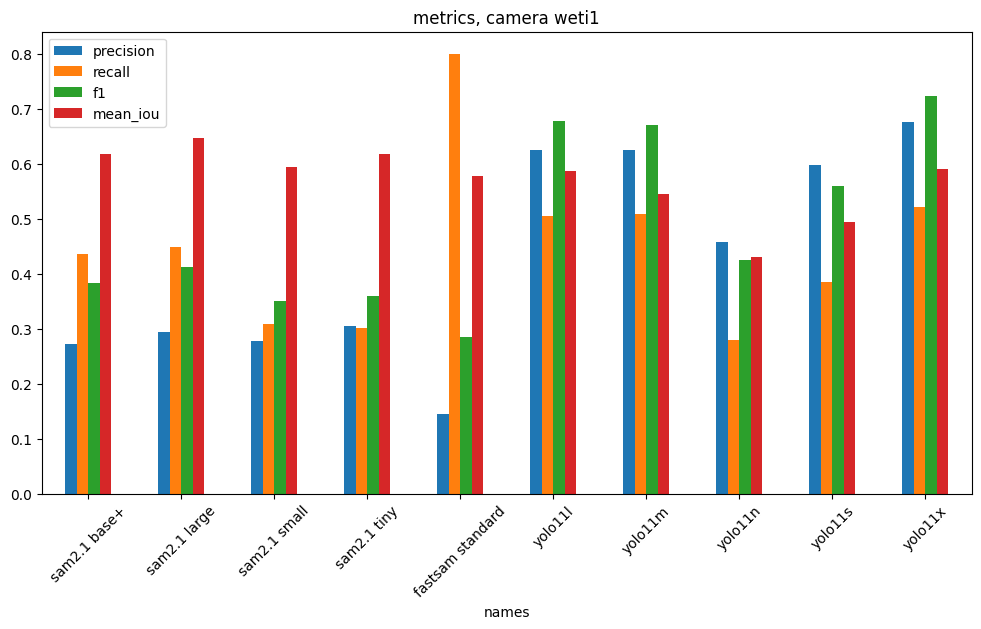

In [37]:
data_models = aggregate_by_model(data, fields=['precision', 'recall', 'f1', 'mean_iou'], name_condition={'include': ['weti1']})
plot_aggregated_data(data_models, 'metrics, camera weti1')

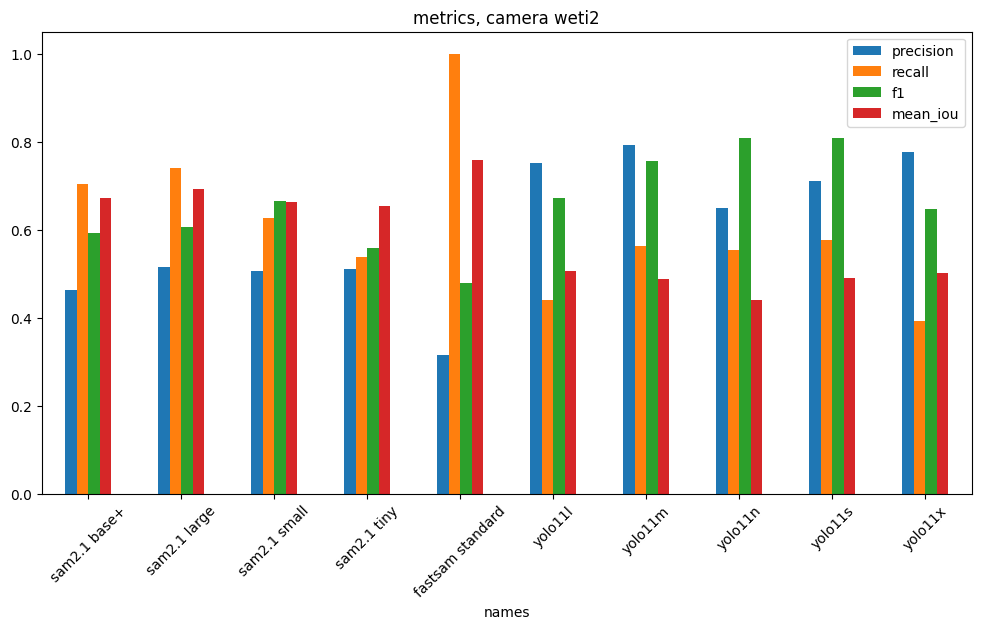

In [39]:
data_models = aggregate_by_model(data, fields=['precision', 'recall', 'f1', 'mean_iou'], name_condition={'include': ['weti2']})
plot_aggregated_data(data_models, 'metrics, camera weti2')

In [45]:
data_models_size_time = aggregate_by_model(data, fields=['time'])
sizes = {
    'sam2.1 tiny': 148,
    'sam2.1 small': 175,
    'sam2.1 base+': 308,
    'sam2.1 large': 856,
    'yolo11l': 49,
    'yolo11m': 38.7,
    'yolo11n': 5.35,
    'yolo11s': 18.4,
    'yolo11x': 109,
    'fastsam standard': 138
}
for k, v in sizes.items():
    data_models_size_time[k]['size [MB]'] = v

    data_models_size_time[k]['time [s]'] = data_models_size_time[k]['time']
    data_models_size_time[k].pop('time')

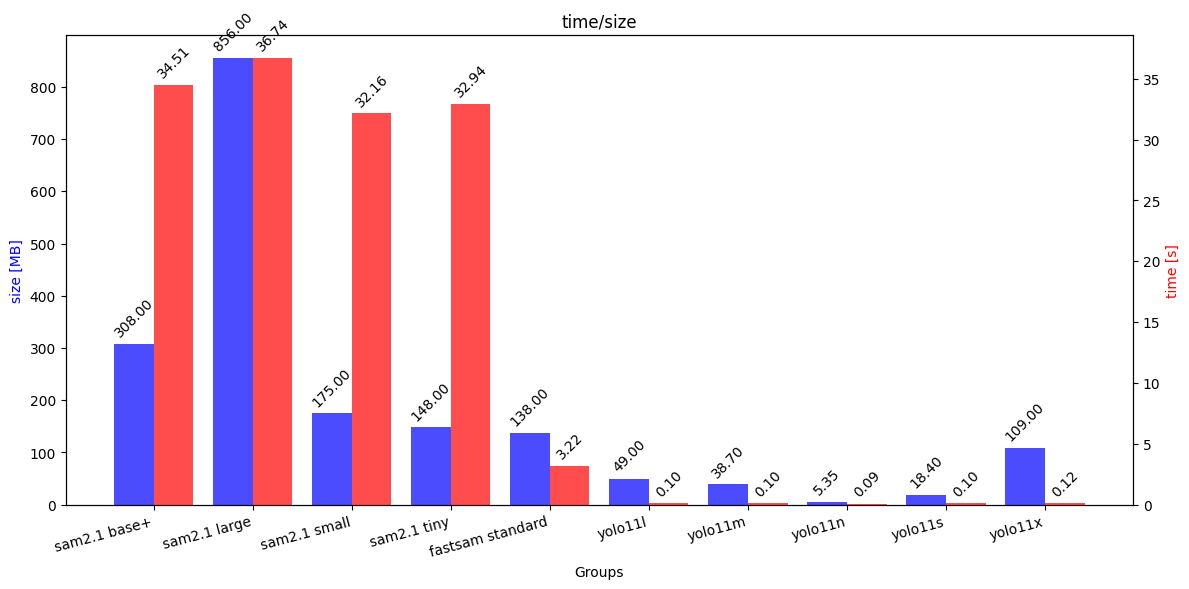

In [46]:
plot_aggregated_data2(data_models_size_time, 'time/size')

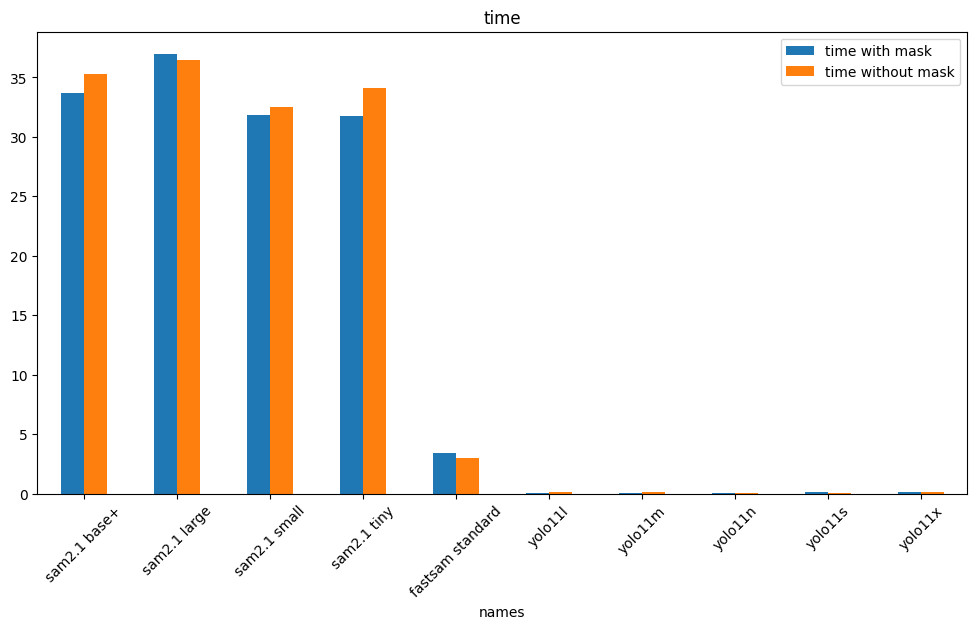

In [66]:
data_models1 = aggregate_by_model(data, fields=['time'], name_condition={'include': ["_m"]})
data_models2 = aggregate_by_model(data, fields=['time'], name_condition={'exclude': ["_m"]})

data_models = {}
for k in data_models1.keys():
    data_models[k] = {}
    for kk, vv in data_models1[k].items():
        data_models[k][f"{kk} with mask"] = vv
    for kk, vv in data_models2[k].items():
        data_models[k][f"{kk} without mask"] = vv
plot_aggregated_data(data_models, 'time')

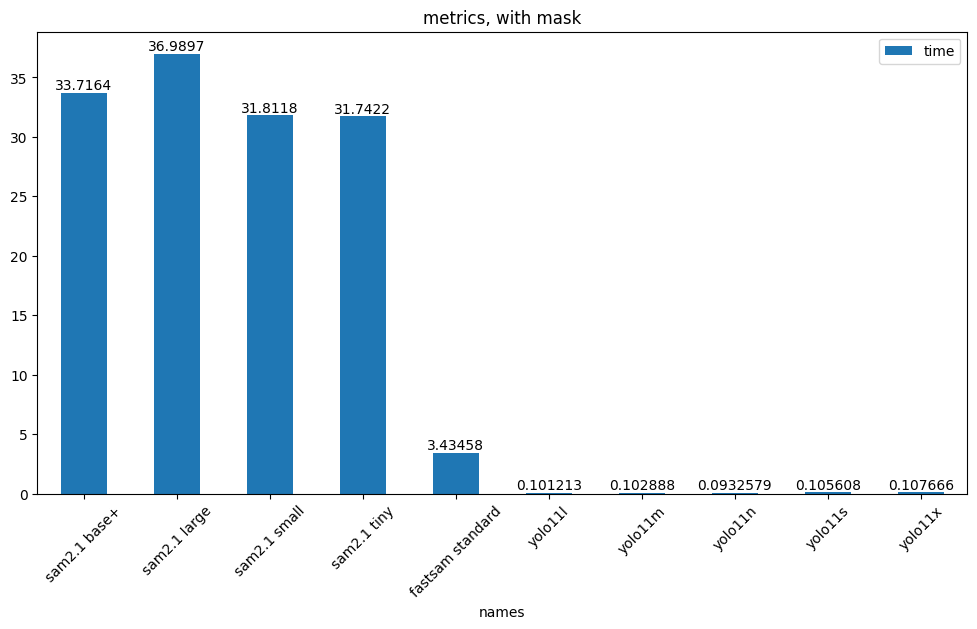

In [67]:
data_models = aggregate_by_model(data, fields=['time'], name_condition={'include': ["_m"]})
plot_aggregated_data(data_models, 'metrics, with mask', print_values=True)

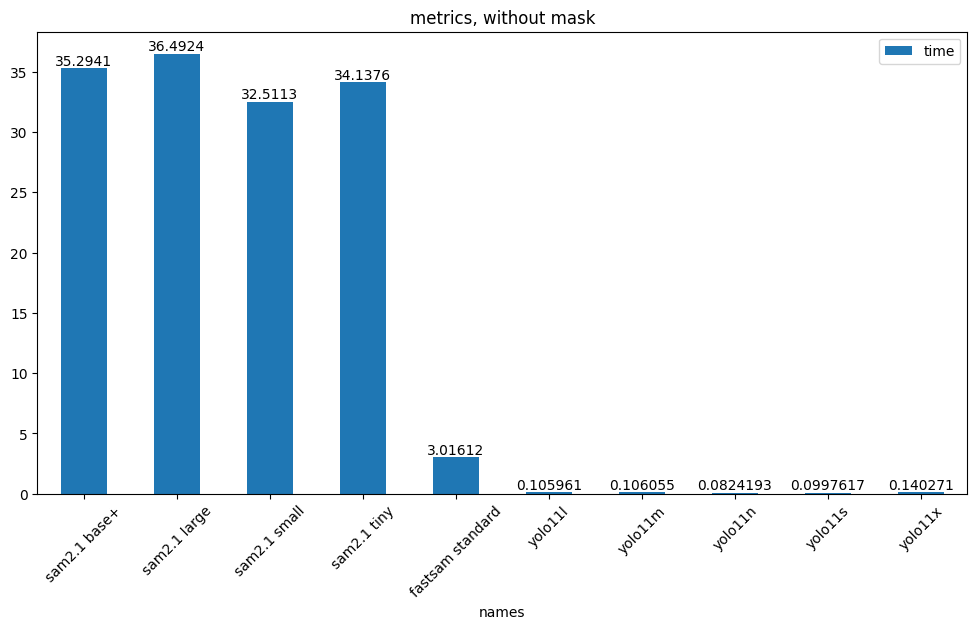

In [59]:
data_models = aggregate_by_model(data, fields=['time'], name_condition={'exclude': ["_m"]})
plot_aggregated_data(data_models, 'metrics, without mask', print_values=True)

### -------------------------------------------